# Seleccion de Variables: Regresión Logistica

En este notebook realizamos una seleccion de variables usando el metodo de validacion cruzada para elegir al conjunto de variables con el cual se obtenga el mejor rendimiento, usando a la regresión logística como modelo de predicción.

Llamamos a las siguientes bibliotecas

In [1]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import auc
import proyecto_ml
from tqdm import tqdm_notebook as tqdm
import warnings
warnings.filterwarnings("ignore")

## Reparaetrización de datos

Para usar regresión logistica debemos reparametrizar los datos, todas las variables de los datos que se usan son variables categoricas que tienen valores numericos, sin embargo, no todos los valores numericos de las variables llevan implicita una noción de orden. Por lo tanto es necesario reparametrizarlas usando one hot encoding, para lo cual empelaremos la siguietes funciones

In [2]:
from sklearn.preprocessing import OneHotEncoder

In [3]:
def reparametrizacion_sklearn(X):
    enc = OneHotEncoder(categories='auto')
    enc.fit(X)
    return pd.DataFrame(enc.transform(X).toarray())

Reparametrizamos los datos

In [4]:
datos = pd.read_csv('datos_seleccionados.csv')
datos_X = datos.drop(columns = ['obesidad'])
datos_reparametrizados = reparametrizacion_sklearn(datos_X)
datos_reparametrizados['obesidad'] = datos['obesidad']

In [5]:
datos_reparametrizados.head(5)

,0,1,2,3,4,5,6,7,8,9,...,182,183,184,185,186,187,188,189,190,obesidad
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0


## Como usar el modelo de regresion logistica con scikit-learn?

En esta parte hacemos una pequeña demostracion de como implementar el modelo de regresion logistica con scikit-learn. Aunque mas adelante, cuando ocupemos implementaciones que involucren mas lineas de codigo las llamaremos del modulo _proyecto_ml_. 

Sin embargo, cabe recalcar que dichas implementaciones son derivadas de esta pequeña muestra.

In [6]:
from sklearn.linear_model import LogisticRegression
logistic_regresion = LogisticRegression(solver='newton-cg',penalty='l2')
X = datos_reparametrizados.drop(columns=(['obesidad']))
Y = datos_reparametrizados['obesidad']
logistic_regresion.fit(X,Y)

LogisticRegression(solver='newton-cg')

Evaluamos el modelo. Debemos recalcar que en esta parte entrenamos y evaluamos el modelo usando todos los datos. Mas adelante dividiremos los datos en conjuntos de validacion y entrenamiento para realizar la seleccion de modelos.

In [7]:
f_prueba = logistic_regresion.predict(X)
proyecto_ml.porcentaje_de_aciertos(Y,f_prueba)

92.93680297397769

Ahora separamos en conjunto de entrenamiento y validacion

In [8]:
datos_train , datos_test = proyecto_ml.dividir_datos(datos,0.7)
X_train = datos_train.drop(columns=['obesidad']) 
X_test = datos_test.drop(columns=['obesidad'])
Y_train = datos_train['obesidad']
Y_test = datos_test['obesidad']
                         
logistic_regresion = LogisticRegression(solver='newton-cg',penalty='l2')
logistic_regresion.fit(X_train,Y_train)
f_test = logistic_regresion.predict(X_test)
proyecto_ml.porcentaje_de_aciertos(f_test,Y_test)

86.687306501548

In [9]:
def seleccion_de_variables(datos, seleccion_de_variables, columna_de_la_clase):
    error_validacion = np.inf
    variables = list(datos.columns)
    variables.remove(columna_de_la_clase)
    
    for variable in variables:
        if variable not in seleccion_de_variables: # no tomamos en cuenta variables que ya esten en el arreglo
            
            datos_seleccionados = datos[ seleccion_de_variables + [variable,columna_de_la_clase] ]
            e_test , e_train = cross_validation(datos_seleccionados, columna_de_la_clase, 50) # numero de particiones
            #print(variable)
            
            if e_test < error_validacion:
                error_validacion = e_test
                error_entrenamiento = e_train
                variable_mas_importante = variable
                
    nueva_seleccion_de_variables = seleccion_de_variables + [variable_mas_importante]
    
    # devuelve una lista con las variables y el error producido de las predicciones con esas variables
    return nueva_seleccion_de_variables , error_validacion , error_entrenamiento 

# Selección de Variables

In [10]:
error_modelo_test = np.inf
seleccion_variables = []
n = len(datos.columns) - 1
errores_test = []
errores_train = []

for i in tqdm(range(n)):
    seleccion_variables, error_test, error_train = proyecto_ml.seleccion_de_variables(datos, seleccion_variables, 'obesidad', 'logistic_regression')
    errores_test.append(error_test)
    errores_train.append(error_train)
    
    if error_test < error_modelo_test:
        variables_optimas = seleccion_variables
        error_modelo_test = error_test

print('Las variables en orden de predictibilidad son:')
print(seleccion_variables)
print('Las variables para el modelo más optimo son:')
print(variables_optimas)
print('El modelo que usa estas variables tuvo un error en los datos de entrenamiento de: ' + str(error_modelo_test))


Las variables en orden de predictibilidad son:
['condi1', 'peso_ehoy', 'Ainsulina', 'aes_peso', 'peso1', 'tgb_com', 'peso5', 'peso_act', 'glu_com', 'mad_diab', 'Ahba', 'com_relrec', 'peso_acc', 'Aedad_diab', 'salud_act', 'condi_act', 'estatura', 'sindro_meta', 'id_gestud', 'locout20', 'Aher6_edad', 'Ahij2_edad', 'dich_hiper', 'Atio_diabeticos', 'peso10', 'condi5', 'Aedad_hiper', 'Ahij_sobrepeso', 'Apuesto', 'estres10']
Las variables para el modelo más optimo son:
['condi1', 'peso_ehoy', 'Ainsulina', 'aes_peso', 'peso1', 'tgb_com', 'peso5', 'peso_act', 'glu_com', 'mad_diab', 'Ahba', 'com_relrec', 'peso_acc', 'Aedad_diab', 'salud_act', 'condi_act', 'estatura', 'sindro_meta', 'id_gestud', 'locout20']
El modelo que usa estas variables tuvo un error en los datos de entrenamiento de: 0.14195046439628484


## Gráfica de Errores

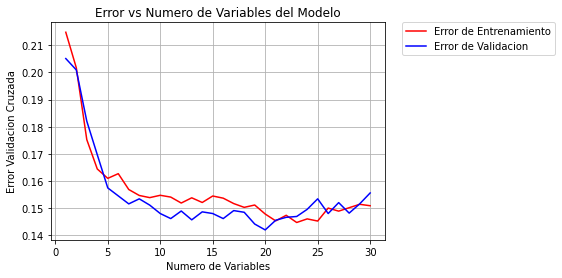

In [11]:
errores_test = np.array(errores_test) 
errores_train = np.array(errores_train) 

dominio = list(range(1,n+1))
plt.plot(dominio,errores_train,'r',label="Error de Entrenamiento")
plt.plot(dominio,errores_test,'b',label="Error de Validacion")
plt.grid(True)
plt.title('Error vs Numero de Variables del Modelo')
plt.xlabel('Numero de Variables')
plt.ylabel('Error Validacion Cruzada')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Prueba de Rendimiento

In [12]:
def promedio_error_y_aciertos_modelo(datos,columna_de_la_clase,iteraciones):

    error_modelo = 0
    porcentaje_aciertos_modelo = 0

    for i in tqdm(range(iteraciones)):
        
        datos_train , datos_test = proyecto_ml.dividir_datos(datos,0.7)
    
        X_train = datos_train.drop(columns = [columna_de_la_clase])
        Y_train = datos_train[columna_de_la_clase]
        X_test = datos_test.drop(columns = [columna_de_la_clase])
        Y_test = datos_test[columna_de_la_clase]
    
        logistic_regresion = LogisticRegression(solver='newton-cg',penalty='l2')
        logistic_regresion.fit(X_train,Y_train)
    
        f_test = logistic_regresion.predict(X_test)
        f_train = logistic_regresion.predict(X_train)
        
        
        error_iteracion = proyecto_ml.error_cuadratico(f_test,Y_test) # calculamos el error cuadratico
        porcentaje_aciertos_iteracion = proyecto_ml.porcentaje_de_aciertos(f_test,Y_test) 
    
        error_modelo = error_modelo + error_iteracion
        porcentaje_aciertos_modelo = porcentaje_aciertos_modelo + porcentaje_aciertos_iteracion

    print('El modelo predijo en promedio correctamente el ' + str(porcentaje_aciertos_modelo/iteraciones) + '% de los datos de test.')
    print('El modelo tuvo en promedio un error cuadratico medio del ' + str(error_modelo/iteraciones) + '% en los datos de test.')    

Probamos el modelo seleccionado

In [15]:
datos_obesidad_modelo_selec = datos[variables_optimas+['obesidad']]
promedio_error_y_aciertos_modelo(datos_obesidad_modelo_selec,'obesidad',100)


El modelo predijo en promedio correctamente el 84.56346749226007% de los datos de test.
El modelo tuvo en promedio un error cuadratico medio del 0.15436532507739936% en los datos de test.
